# MIDI music generation with GAN
In this notebook we'll be presenting various approaches for training a GAN model that generates music in the form of MIDI (Musical Instrument Digital Interface) files.

Notebook presented for the A.A. 2023/2024 Deep Learning project.

Group members:
- Valerio Di Zio - valerio.dizio@studio.unibo.it
- Francesco Magnani - francesco.magnani14@studio.unibo.it
- Luca Rubboli - mail@diluca.it

## Installation of libraries

In this notebook only 3 additional libraries are needed (plus the ones already installed on Colab runtimes):
- `pretty_midi` is a utility library to manage MIDI files
- `miditok` is library that provides several implementations of MIDI tokenization algorithms, useful for training AI models on tokens that represent MIDI data
- `transformers` is a popular library for building and training AI models

In [ ]:
%%capture
!pip install pretty_midi
!pip install gdown
!pip install miditok
!pip install midi-clip

!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

## Dataset Download

We will use the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro) for training the first Transformer model.

This dataset contains MIDI files taken from several piano performances.

In [ ]:
%%capture
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
!unzip 'maestro-v3.0.0-midi.zip'
!rm 'maestro-v3.0.0-midi.zip'
dataset_path = "maestro-v3.0.0"

## Libraries
Here we import all the necessary libraries for this notebook.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import glob

import os
import random
import datetime
import shutil
from pathlib import Path
import pretty_midi
import numpy as np
from miditok import REMI, TokenizerConfig
import json
from miditok.utils import split_files_for_training
from miditok.data_augmentation import augment_dataset
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
import pickle

from IPython import display

## File setup

Before processing the MIDI files, we first organize them by moving each file into a new folder named midis and renaming them sequentially using integer indices.

In [ ]:
_SAMPLING_RATE = 16000

def display_audio(file, seconds=30):
  pm = pretty_midi.PrettyMIDI(file)
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)

  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
midi_paths = list(Path(dataset_path).resolve().glob("**/*.mid")) + list(Path(dataset_path).resolve().glob("**/*.midi"))

midis_dir = "midis"
os.makedirs(midis_dir, exist_ok=True)


for i, midi_path in enumerate(midi_paths):
  new_midi_path = os.path.join(midis_dir, f"{i}.midi")
  shutil.move(str(midi_path), new_midi_path)


midis = list(Path("midis").resolve().glob("**/*.mid")) + list(Path("midis").resolve().glob("**/*.midi"))

def sample():
  return str(random.choice(midis))

# Data analysis and preparation



## MIDI format

The **MIDI** (Musical Instrument Digital Interface) file format is a standard for representing musical performance data. It doesn’t store actual audio but rather instructions for playback, such as notes, timing, and instrument settings.

The key components contained inside MIDI files are:
1.	**Tracks**: MIDI files contain one or more tracks, each holding a sequence of events.
2.	**Events**:
  - *Note On/Off*: Indicates when a note starts and stops, along with its pitch and velocity (volume).
	- *Control Changes*: Adjust settings like volume, pan, or effects.
	- *Program Changes*: Switches instruments (e.g. piano to guitar).
	- *Meta Events*: Provide additional information like tempo, time signature, and track names.
3.	**Channels**: MIDI supports up to 16 channels, each typically assigned to a different instrument.
4.	**Timing**: MIDI uses ticks (subdivisions of a beat) to precisely time events.

Many python libraries to handle MIDI files exist, here `pretty_midi` will be used as it appears sufficiently flexible and easy to use.

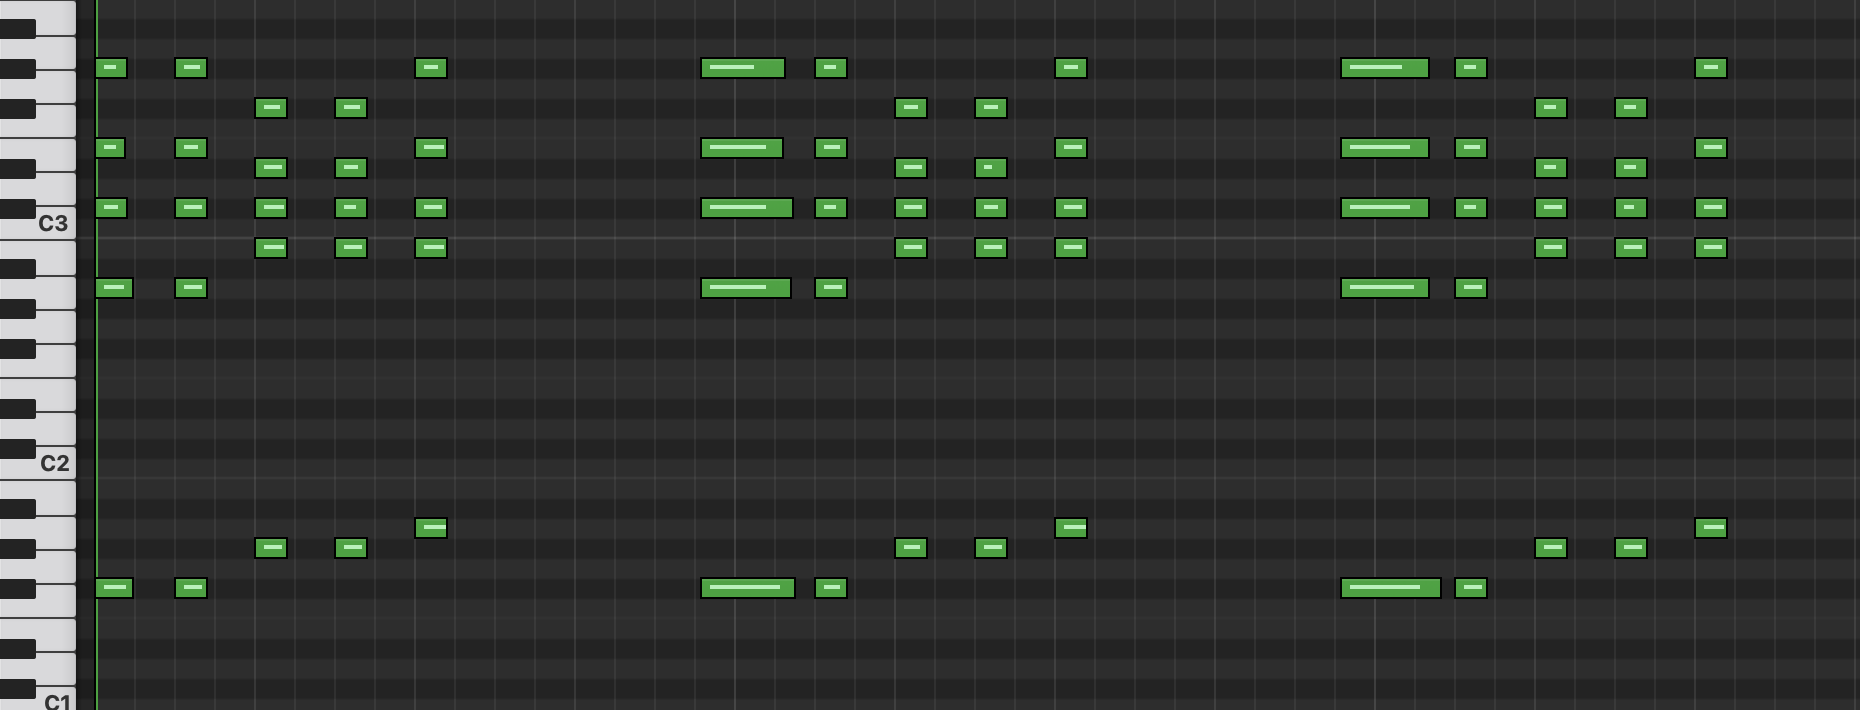

## Tokenization

We cannot directly use MIDI files as input for an AI model, so we must transform them into a numerical representation, similar to how text data is processed for models. To achieve this, we need a **tokenizer**.

A tokenizer is a tool that converts the raw MIDI data into a sequence of *tokens* that the AI model can understand.

In the context of MIDI tokenization, each token represents a specific musical element or event, such as a note, velocity, or duration. These tokens act as the “vocabulary” for the model, enabling it to learn and generate music.

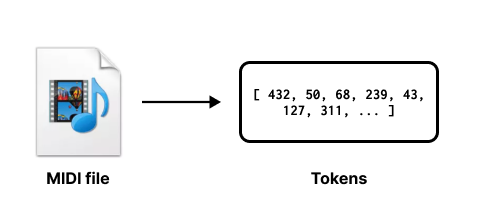

### MidiTok

The MidiTok library provides predefined tokenization methods (e.g. **REMI**) to translate MIDI events into tokens and vice versa, ensuring a structured and efficient representation of musical data.

Compared to the previous tokenization method, MidiTok allows for a more comprehensive translation of MIDI events into tokens, with less information loss.

In [ ]:
BEAT_RES = {(0, 1): 12, (1, 2): 4, (2, 4): 2, (4, 8): 1}

TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": BEAT_RES,
    "num_velocities": 3,
    "special_tokens": ["BOS", "EOS"],
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "num_tempos": 8,
    "tempo_range": (50, 200),  # (min_tempo, max_tempo),
}

config = TokenizerConfig(**TOKENIZER_PARAMS)

tokenizer = REMI(config)

### (Optional): train the tokenizer

One of the features that MidiTok offers is the **training of a tokenizer**.
Taken from MidiTok's documentation:

> Training a tokenizer consists in populating the vocabulary with new tokens representing successions of these basic tokens, that will be fetched from a training corpus. [...] For symbolic music, training the tokenizer allows to **increase both the model’s performances and efficiency**.

In order to do that, MidiTok uses algorithms like **Byte Pair Encoding (BPE)** to "pack" groups of tokens that appear frequently in the dataset into new tokens of the vocabulary.

The explanation for why this technique can improve the model’s performance is quite simple: the model’s “effort” in generating meaningful token sequences is reduced. Instead of learning to produce multiple “correct” tokens in sequence, it can directly produce a single token that corresponds to that sequence of MIDI events.

In [ ]:
# @title Manually train the tokenizer
TRAIN_TOKENIZER = False # @param { type: 'boolean' }

In [ ]:
vocab_size = 5000
if TRAIN_TOKENIZER:
  tokenizer.train(vocab_size=vocab_size, files_paths=midis)
  processed = [Path(f"{s}") for s in midis]
  print(len(processed))

1276
/kaggle/working/midis/578.midi


Performing data augmentation: 100%|██████████| 11503/11503 [00:30<00:00, 373.97it/s]


/kaggle/working/midis/571.midi


Performing data augmentation: 100%|██████████| 716/716 [00:02<00:00, 355.12it/s]


### Load a trained tokenizer

To avoid re-training a tokenizer from scratch, here we provide an already trained one.

In [ ]:
!gdown 1Uf734gntq6RLpAvcruWuKcHqPmcZ_4O8 # gan_tokenizer.json
tokenizer = REMI(params="gan_tokenizer.json")

## Dataset preparation

In the following cells we prepare the dataset for training by splitting it into Train, Validation and Test sets. In addition, we exploit some methods made available by MidiTok to perform data augmentation.

### Download the clean data

If you want to skip all the data preparation, here we provide the data already cleaned and tokenized, in the form of numpy arrays.

In [ ]:
!gdown 1VU4ngttqwACFEtnv7l6B8xG2Z1eS3GWZ # ids_train_1227.txt
!gdown 1c8hgL4J2BVS4_XXuZNlkuTRYEHduZTdy # ids_valid_1227.txt

all_ids_train = np.loadtxt("ids_train_1227.txt").astype(dtype=np.int32)
all_ids_valid = np.loadtxt("ids_valid_1227.txt").astype(dtype=np.int32)

In [ ]:
# @title ### (Optional): skip all the data preparation
SKIP_DATA_PREPARATION = True # @param { type: 'boolean' }

In [ ]:
if not SKIP_DATA_PREPARATION:
  valid_perc = 0.05
  augment = True

  total_num_files = len(processed)
  num_files_valid = round(total_num_files * valid_perc)
  shuffle(processed)
  midi_paths_valid = processed[:num_files_valid]
  midi_paths_train = processed[num_files_valid:]

  # Chunk MIDIs and perform data augmentation on each subset independently

  for files_paths, subset_name in (
      (midi_paths_train, "train"),
      (midi_paths_valid, "valid"),
  ):
      print(files_paths[0])

      # Split the MIDIs into chunks of sizes approximately about 1024 tokens
      subset_chunks_dir = Path(f"Maestro_{subset_name}")

      split_files_for_training(
          files_paths=files_paths,
          tokenizer=tokenizer,
          save_dir=subset_chunks_dir,
          max_seq_len=1024,
          num_overlap_bars=2,
      )

      # Perform data augmentation
      if augment:
          augment_dataset(
              subset_chunks_dir,
              pitch_offsets=[-12, 12],
              velocity_offsets=[-3, 3],
              duration_offsets=[-0.5, 0.5],
          )

  midi_paths_train = list(Path("Maestro_train").glob("**/*.mid")) + list(Path("Maestro_train").glob("**/*.midi"))
  midi_paths_valid = list(Path("Maestro_valid").glob("**/*.mid")) + list(Path("Maestro_valid").glob("**/*.midi"))

### Tokenization

Here we tokenize the augmented dataset into JSON files containing the IDs of the tokens.

In [ ]:
if not SKIP_DATA_PREPARATION:
  def midi_valid(midi) -> bool:

      if any(ts.numerator != 4 for ts in midi.time_signature_changes):

          return False  # time signature different from 4/*, 4 beats per bar

      return True



  if os.path.exists("tokenized"):

    shutil.rmtree("tokenized")


  for dir in ("train", "valid"):
      tokenizer.tokenize_dataset(

          Path(f"Maestro_{dir}"),
          Path(f"tokenized_{dir}"),
          midi_valid,

      )

Tokenizing music files (working/tokenized_valid): 100%|██████████| 4299/4299 [01:46<00:00, 40.39it/s]


### Read JSON files

Here we read the produced JSON files containing MidiTok tokenization's output.

In [ ]:
if not SKIP_DATA_PREPARATION:
  def read_json(path: str) -> dict:

    with open(path, "r") as f:

      return json.load(f)

  def read_json_files(json_file_paths):
      """Reads a list of JSON files and returns a list of objects.
      Args:
          json_file_paths: A list of file paths to JSON files.
      Returns:
          A list of objects, where each object represents the data from a JSON file.
          Returns an empty list if any error occurs during file processing.
      """

      objects = []

      for file_path in tqdm(json_file_paths):

          try:

              objects.append(read_json(file_path))

          except FileNotFoundError:

              print(f"Error: File not found - {file_path}")

              return []

          except json.JSONDecodeError:

              print(f"Error decoding JSON in file: {file_path}")

              return []

      return objects

In [ ]:
if not SKIP_DATA_PREPARATION:
  tokenized_train = list(Path("tokenized_train").resolve().glob("**/*.json"))
  data_objects_train = read_json_files(tokenized_train)

  tokenized_valid = list(Path("tokenized_valid").resolve().glob("**/*.json"))
  data_objects_valid = read_json_files(tokenized_valid)

  if data_objects_train:
      print(f"\nSuccessfully read {len(data_objects_train)} training JSON files.")
  else:
      print("Error reading JSON files.")

100%|██████████| 4299/4299 [00:00<00:00, 6767.58it/s]


Successfully read 68872 training JSON files.


### Concatenate all IDs into a numpy array

Instead of working with padded songs (where each MIDI file, translated into tokens, is padded with a special padding token to reach a fixed length), we adopt a different approach. The token IDs of all piano pieces are concatenated into a single, large NumPy array.

While this method has clear drawbacks — such as reduced musical coherence when feeding the data into the model and a diminished sense of a song “as a whole” — it offers significantly greater flexibility in managing the data.

In [ ]:
if not SKIP_DATA_PREPARATION:
  encoded_train = [np.array(song["ids"][0]) for song in data_objects_train]
  encoded_valid = [np.array(song["ids"][0]) for song in data_objects_valid]
  all_ids_train = np.concatenate(encoded_train)
  all_ids_valid = np.concatenate(encoded_valid)

  all_ids_train = all_ids_train.astype(dtype=np.int32)
  all_ids_valid = all_ids_valid.astype(dtype=np.int32)

# Model


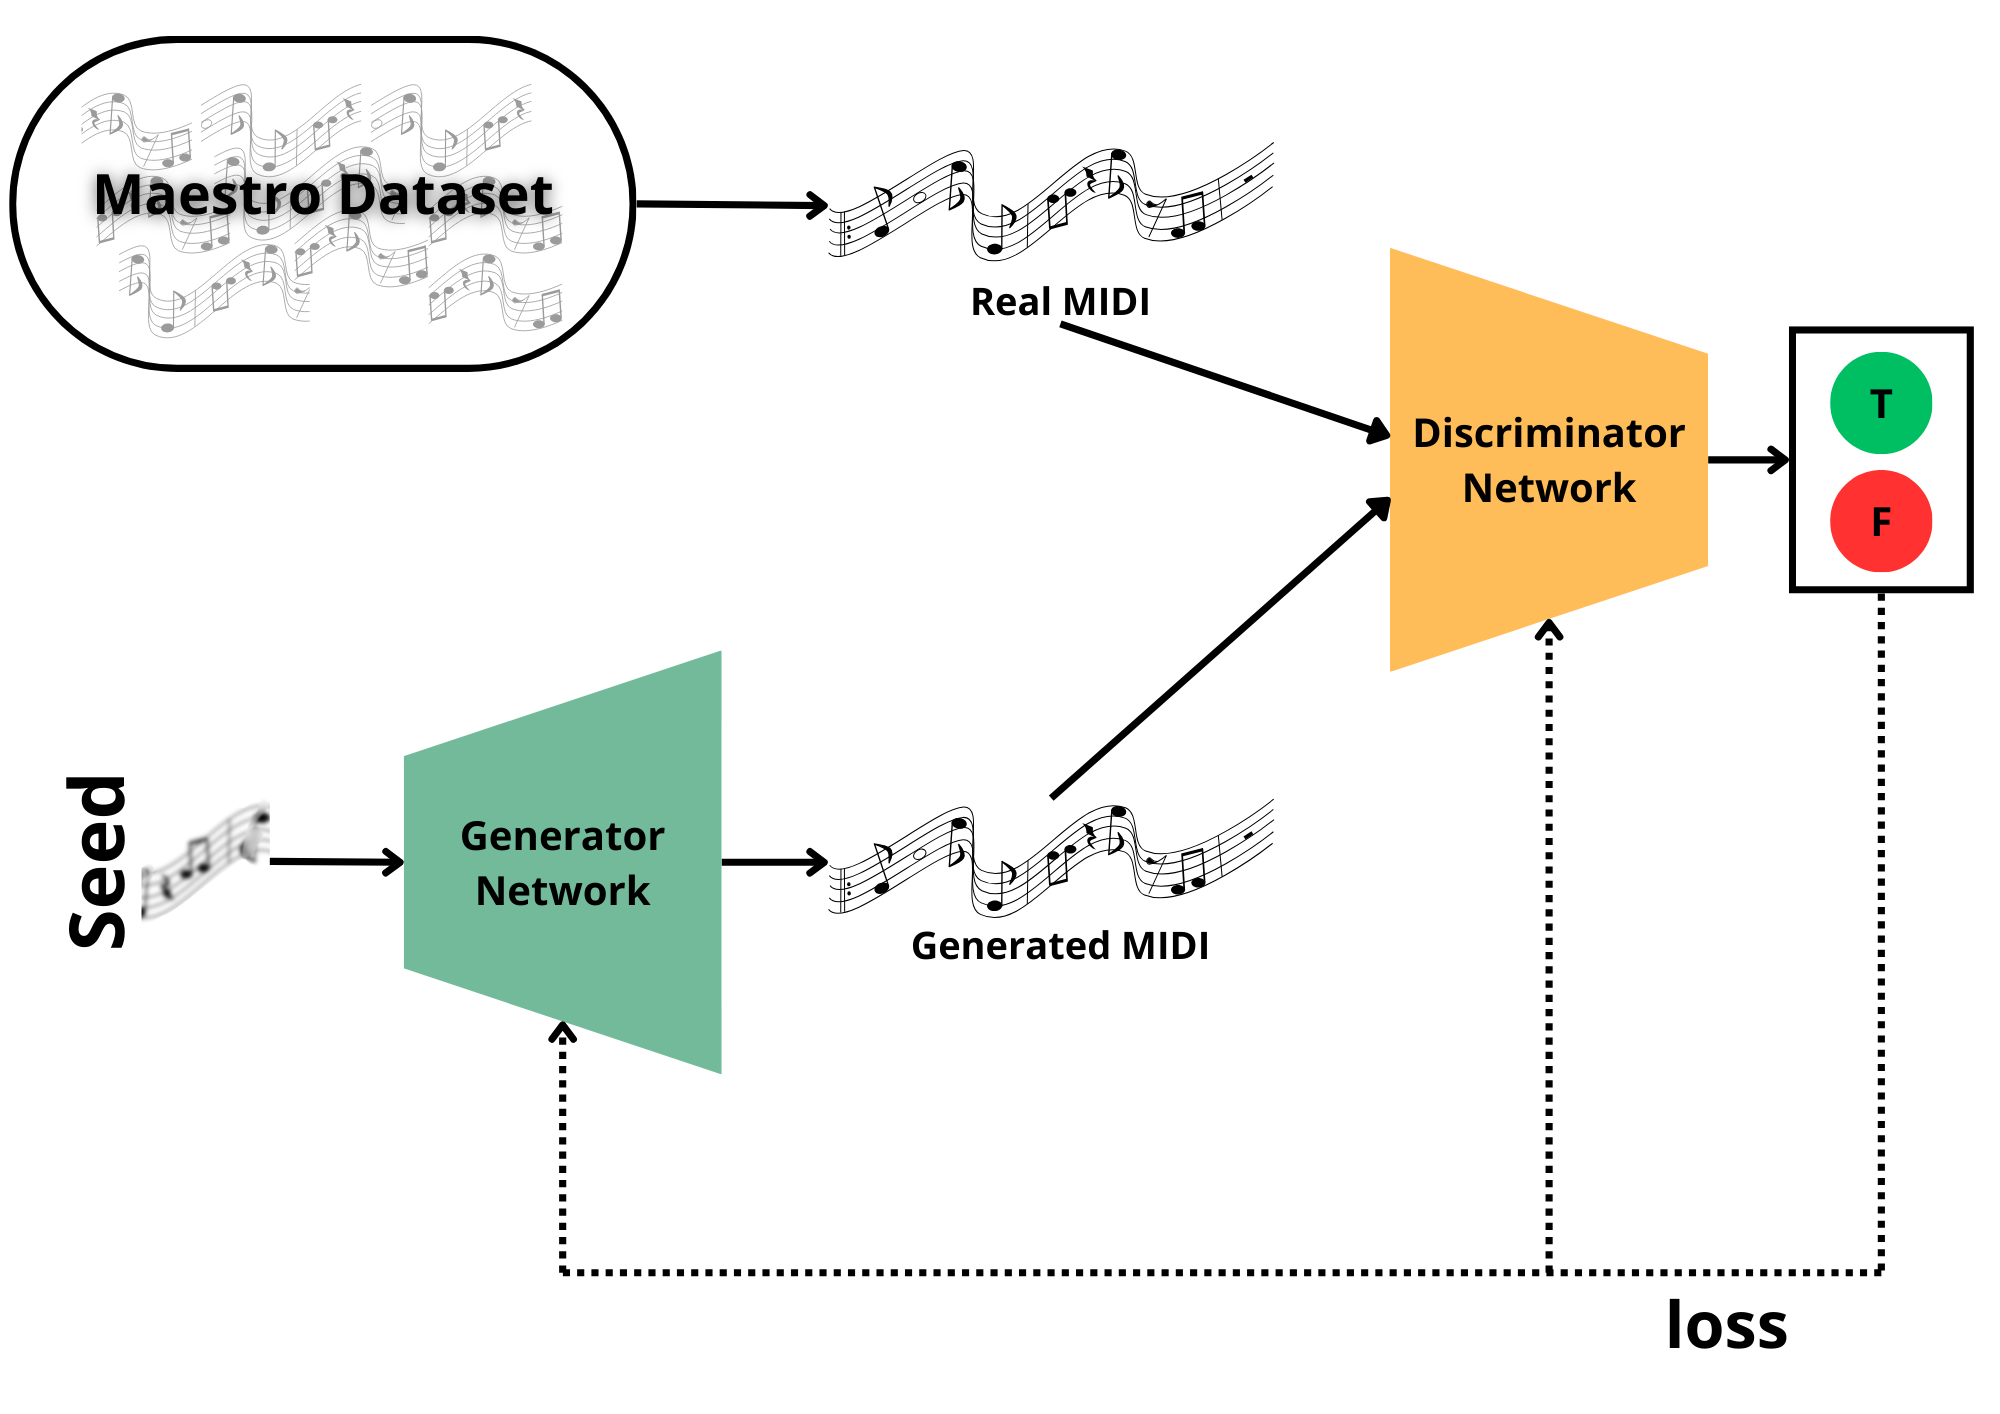

## Generator (choose one)

In [ ]:
class GenLSTM(nn.Module):
    def __init__(self, noise_dim, hidden_dim, seq_length, num_layers, drop_rate=0.3):
        super(GenLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        self.dropout = nn.Dropout(drop_rate)

        self.fc1 = nn.Linear(hidden_dim, seq_length)
        self.bn1 = nn.BatchNorm1d(noise_dim)
        self.lrelu1 = nn.ReLU(inplace=True)


        self.fc2 = nn.Linear(seq_length, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        Forward pass of the Generator.

        Args:
            x (torch.Tensor): Input noise of shape (batch_size, latent_dim, 1).

        Returns:
            torch.Tensor: Output sequence of shape (batch_size, latent_dim, output_dim).
        """
        x, _ = self.lstm(x)

        x = self.dropout(x)

        x = self.fc1(x)
        x = self.lrelu1(x)

        x = self.fc2(x)
        return self.tanh(x)

class GenFC1(nn.Module):
    def __init__(self, noise_dim, hidden_dim, seq_length):
        super(GenFC1, self).__init__()

        self.fc1 = nn.Linear(noise_dim, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, seq_length)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # Output will be of shape (batch_size, seq_length)
        return x


class GenFC4(nn.Module):
    def __init__(self, noise_dim, hidden_dim, seq_length):
        super(GenFC4, self).__init__()

        # Deeper and larger network
        self.fc1 = nn.Linear(noise_dim, hidden_dim * 16)
        self.fc2 = nn.Linear(hidden_dim * 16, hidden_dim * 8)
        self.fc3 = nn.Linear(hidden_dim * 8, hidden_dim * 4)
        self.fc4 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc5 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, seq_length)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.fc6(x)
        return torch.tanh(x)

## Discriminator (choose one)

In [ ]:
class DiscLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(DiscLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.leaky_relu2 = nn.LeakyReLU(0.3)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x):
        # LSTM expects input as (batch_size, seq_len, input_dim)
        _, (h_n, _) = self.lstm(x)  # Only use the last hidden state (h_n)
        x = h_n[-1]  # h_n contains layers, take the last layer's output
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.fc3(x)
        return x

class DiscFC1(nn.Module):
    def __init__(self, seq_length, hidden_dim):
        super(DiscFC1, self).__init__()

        self.fc1 = nn.Linear(seq_length, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)  # Final layer to output a scalar (real/fake)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class DiscFC4(nn.Module):
    def __init__(self, seq_length, hidden_dim):
        super(DiscFC4, self).__init__()

        # More powerful and deeper network
        self.fc1 = nn.Linear(seq_length, hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.fc3 = nn.Linear(hidden_dim * 4, hidden_dim * 8)
        self.fc4 = nn.Linear(hidden_dim * 8, hidden_dim * 16)
        self.fc5 = nn.Linear(hidden_dim * 16, 1)

        self.leaky_relu = torch.nn.LeakyReLU(negative_slope=0.2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(self.leaky_relu(self.fc2(x)))
        x = self.dropout(self.leaky_relu(self.fc3(x)))
        x = self.dropout(self.leaky_relu(self.fc4(x)))
        x = self.fc5(x)
        return x

# Hyper-parameters and models

In [ ]:
def get_model(name: str, config: dict):
    if name == "gen_fc1":
        return GenFC1(**config)
    elif name == "gen_fc4":
        return GenFC4(**config)
    elif name == "gen_lstm":
        return GenLSTM(**config)
    elif name == "disc_fc1":
        return DiscFC1(**config)
    elif name == "disc_fc4":
        return DiscFC4(**config)
    elif name == "disc_lstm":
        return DiscLSTM(**config)
    else:
        raise KeyError("Unknown model")

vocab_size = len(tokenizer)
seq_length = 512
noise_dim = 512
batch_size = 128

generator_config = {
    "noise_dim"  : noise_dim,
    "hidden_dim" : 1536,
    "seq_length" : seq_length
}


discriminator_config = {
    "seq_length" : seq_length,
    "hidden_dim" : 1536
}

generator = get_model("gen_fc4", generator_config)
discriminator = get_model("disc_fc4", discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "seq_length"               : seq_length,
    "tokenizer"                : tokenizer,
}

## GAN class

In [ ]:
class GAN:
    def __init__(self,
                 generator,
                 discriminator,
                 noise_dim,
                 seq_length,
                 tokenizer,
                 loss = nn.BCEWithLogitsLoss(),
                ):
        self.G = generator
        self.D = discriminator
        self.noise_dim = noise_dim
        self.seq_length = seq_length
        self.loss = loss

        self.optimizer_G = torch.optim.Adam(self.G.parameters(), lr=0.00005, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(self.D.parameters(), lr=0.00005, betas=(0.5, 0.999))
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer)

        def init_weights(m):
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

        # Initialize all layers
        self.G.apply(init_weights)
        self.D.apply(init_weights)

    def _weights_init(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

    def noise(self, size, device):
        return torch.randn(size, self.noise_dim, device=device)

    def _G_train_step(self, batch_size, device):
        self.G.zero_grad()

        # Generate fake data
        fake_noise = self.noise(batch_size, device)
        fake_data = self.G(fake_noise)

        # Discriminator prediction on fake data
        fake_preds = self.D(fake_data)

        epsilon = 1e-8
        loss_G = -torch.mean(fake_preds)

        # Check for NaNs and clip gradients
        if torch.isnan(loss_G).any() or torch.isinf(loss_G).any():
            print(f"NaN or Inf detected in G Loss")
        else:
            loss_G.backward()
            torch.nn.utils.clip_grad_norm_(self.G.parameters(), max_norm=1.0)
            self.optimizer_G.step()

        return loss_G

    def _D_train_step(self, batch_size, real_data, device):
        self.D.zero_grad()

        fake_noise = self.noise(batch_size, device)
        fake_data = self.G(fake_noise)
        #print(f"Fake data in D step {fake_data}")
        #print(f"Real data in D step {real_data}")

        real_preds = self.D(real_data)
        fake_preds = self.D(fake_data)
        #print(f"Real Preds in D step {real_preds}")
        #print(f"Fake Preds in D step {torch.mean(fake_preds)}")

        real_labels = torch.ones_like(real_preds)
        fake_labels = torch.zeros_like(fake_preds)

        loss_real = self.loss(real_preds, real_labels)
        loss_fake = self.loss(fake_preds, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        self.optimizer_D.step()

        if torch.isnan(loss_D).any() or torch.isinf(loss_D).any():
            print(f"NaN or Inf detected in D Loss")

        return loss_D

    def _train_step(self, batch_size, real_data, device, gen_steps=1, disc_steps=1):
        losses_D = []
        losses_G = []
        for i in range(disc_steps):
            losses_D.append(self._D_train_step(batch_size, real_data, device))
        for i in range(gen_steps):
            losses_G.append(self._G_train_step(batch_size, device))
        return (losses_D, losses_G)


    def train(
        self,
        dataloader,
        epochs,
        device,
        loss_delta=0.7,
        steps_each_print=5,
        advantage_steps=2,
        alternate_training=False,
        gen_steps=1,
        disc_steps=1,
    ):
        print(f"Starting training with {epochs} epochs")
        self.G = self.G.to(device)
        self.D = self.D.to(device)
        self.G.train(True)
        self.D.train(True)

        iteration_count = len(dataloader)
        batch_size = dataloader.batch_size

        disc_steps = disc_steps
        gen_steps = gen_steps

        final_losses_D = []
        final_losses_G = []

        for epoch in range(epochs):
            pbar = tqdm(total=iteration_count, position=0, leave=True)
            for step, real_data in enumerate(dataloader):
                batch_size = real_data.size(0)
                real_data = real_data.to(device)

                losses_D, losses_G = self._train_step(batch_size, real_data, device, gen_steps, disc_steps)
                losses_D = [loss.cpu().item() for loss in losses_D]  # Convert each loss to a scalar
                losses_G = [loss.cpu().item() for loss in losses_G]
                loss_D, loss_G = (np.mean(losses_D), np.mean(losses_G))
                final_losses_D.append(loss_D)
                final_losses_G.append(loss_G)

                if alternate_training:
                    if loss_G - loss_D > loss_delta:
                        gen_steps = advantage_steps
                        disc_steps = 1
                    elif loss_D - loss_G  > loss_delta:
                        disc_steps = advantage_steps
                        gen_steps = 1
                    else:
                        gen_steps = 1
                        disc_steps = 1

                if (step + 1) % steps_each_print == 0:
                    description = f"D Loss: {loss_D:.4f}, G Loss: {loss_G:.4f}"
                    if gen_steps != 1 or disc_steps != 1:
                        description = description + f", D Steps: {disc_steps}, G Steps: {gen_steps}"
                    pbar.set_description(description)
                    pbar.update(steps_each_print)
            pbar.n = pbar.total
            pbar.refresh()
            pbar.close()

            print(f'Epoch [{epoch+1}/{epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')

        return final_losses_D, final_losses_G

    def save_generator(self, directory):
        torch.save(self.G, directory)

    def predict(self, n, device):
        z = self.noise(n, device)# Random Noise
        return self.G(z).cpu().detach().numpy()

    def generate(self, n, base_output_name, device):
        normalized_predictions = self.predict(n, device)
        boundary = int(len(tokenizer) / 2)
        predictions = [x * boundary + boundary for x in normalized_predictions]
        for i in range(len(predictions)):
            pred = predictions[i]                                # [[5.0], [6.0], [7.0]]
            pred_tokens = pred.astype(np.int32)                  # [5, 6, 7]
            pred_tokens[pred_tokens == len(tokenizer)] = 0       # if some value equals vocab_size, replace with empty tokens
            try:
                decoded = tokenizer.decode([pred_tokens])
                decoded.dump_midi(f"{base_output_name}_{i}.mid")
            except Exception as e:
                print(e)


    def generate_and_show(self, n, base_output_name, device):
        name = f"{base_output_name}_0.mid"
        self.generate(n, base_output_name, device)
        display_audio(name)


gan = GAN(**gan_params)

# Training

## Prepare data

In [ ]:
# Dataset personalizzato
class TokenDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

vocab_size = len(tokenizer)

def normalize_data(data, vocab_size, interval=(-1, 1)):
    min_val, max_val = interval
    normalized_data = (data - vocab_size / 2) / (vocab_size / 2)
    scaled_data = normalized_data * (max_val - min_val) / 2 + (max_val + min_val) / 2

    return scaled_data

normalized_seq = normalize_data(all_ids_train, vocab_size)
print(f"Max is {normalized_seq.max()}, Min is {normalized_seq.min()}")

all_ids_train_seq = [normalized_seq[i:i + seq_length]
                 for i in range(0, len(normalized_seq) - seq_length, seq_length)]

dataset = TokenDataset(all_ids_train_seq)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
_ = torch.ones(1, device='cuda')  # Dummy operation to initialize CUDA

Max is 0.9996, Min is -0.9988


## Start the training

In [ ]:
!gdown 1XN71Mnc3C4gzr1w8u5xgcOAsX9zNds-m
gan = torch.load("./NESGEN_gan50")
!rm NESGEN_gan50

Downloading...
From (original): https://drive.google.com/uc?id=1XN71Mnc3C4gzr1w8u5xgcOAsX9zNds-m
From (redirected): https://drive.google.com/uc?id=1XN71Mnc3C4gzr1w8u5xgcOAsX9zNds-m&confirm=t&uuid=141db13f-0e8b-446b-b250-6d6b2a0d91e9
To: /content/NESGEN_gan50
100% 1.66G/1.66G [00:16<00:00, 101MB/s]


<ipython-input-15-1c1ff281cded>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gan = torch.load("./NESGEN_gan50", map_location=torch.device('cpu'))


In [ ]:
TRAIN = False

training_arguments = {
    "dataloader"         : dataloader,
    "epochs"             : 50,
    "device"             : device,
    "steps_each_print"   : 10,
    "gen_steps"          : 1,
    "disc_steps"         : 1,
}
if TRAIN:
  losses_D, losses_G = gan.train(**training_arguments)

Starting training with 50 epochs


D Loss: 0.5984, G Loss: 2.6818: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [1/50] Loss D: 0.7622, Loss G: 0.6918


D Loss: 0.4700, G Loss: 3.4135: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [2/50] Loss D: 0.1604, Loss G: 3.9304


D Loss: 1.4177, G Loss: -0.0366: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [3/50] Loss D: 1.4041, Loss G: 0.0746


D Loss: 1.4074, G Loss: -0.0023: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [4/50] Loss D: 1.3883, Loss G: 0.1567


D Loss: 1.4085, G Loss: -0.0748: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [5/50] Loss D: 1.3902, Loss G: -0.0699


D Loss: 0.6622, G Loss: 2.2217: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [6/50] Loss D: 0.5523, Loss G: 0.3722


D Loss: 1.3849, G Loss: 0.0040: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [7/50] Loss D: 1.3995, Loss G: -0.1070


D Loss: 1.3652, G Loss: 0.1761: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [8/50] Loss D: 1.4339, Loss G: -0.0903


D Loss: 1.3846, G Loss: 0.0507: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [9/50] Loss D: 1.3892, Loss G: -0.0091


D Loss: 0.3481, G Loss: 5.2150: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s] 


Epoch [10/50] Loss D: 0.2316, Loss G: 4.3078


D Loss: 0.8545, G Loss: 1.3671: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [11/50] Loss D: 0.7809, Loss G: 1.8631


D Loss: 0.6475, G Loss: 1.9638: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [12/50] Loss D: 1.4278, Loss G: 4.8780


D Loss: 1.1500, G Loss: 1.5318: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [13/50] Loss D: 1.0768, Loss G: 1.5130


D Loss: 1.0032, G Loss: 2.3515: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [14/50] Loss D: 1.1919, Loss G: 0.9610


D Loss: 1.2107, G Loss: 1.0572: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [15/50] Loss D: 1.1955, Loss G: 1.1433


D Loss: 1.1653, G Loss: 0.4538: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [16/50] Loss D: 1.2562, Loss G: 1.1275


D Loss: 1.2905, G Loss: 0.5448: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [17/50] Loss D: 1.5029, Loss G: 0.1861


D Loss: 1.1544, G Loss: 2.3527: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [18/50] Loss D: 1.1468, Loss G: 1.1833


D Loss: 1.2934, G Loss: 0.6150: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [19/50] Loss D: 1.1981, Loss G: 0.7968


D Loss: 1.3908, G Loss: 0.2937: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [20/50] Loss D: 1.3321, Loss G: 0.3502


D Loss: 1.2697, G Loss: 0.5011: 100%|██████████| 1066/1066 [07:02<00:00,  2.53it/s]


Epoch [21/50] Loss D: 1.2953, Loss G: 0.4914


D Loss: 1.3106, G Loss: 0.3412: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [22/50] Loss D: 1.3318, Loss G: 0.2598


D Loss: 1.2932, G Loss: 0.3982: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [23/50] Loss D: 1.3441, Loss G: 0.4159


D Loss: 1.7141, G Loss: 0.9675: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [24/50] Loss D: 1.3750, Loss G: 0.1754


D Loss: 1.4259, G Loss: -0.0800: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [25/50] Loss D: 1.3921, Loss G: 0.1031


D Loss: 1.2892, G Loss: 0.1610: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [26/50] Loss D: 1.2109, Loss G: 0.5031


D Loss: 1.2831, G Loss: 0.4142: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [27/50] Loss D: 1.3441, Loss G: 0.3398


D Loss: 1.2907, G Loss: 0.2401: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [28/50] Loss D: 1.2646, Loss G: 0.7836


D Loss: 1.3256, G Loss: 0.2187: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [29/50] Loss D: 1.3961, Loss G: 0.0239


D Loss: 1.3644, G Loss: 0.1297: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [30/50] Loss D: 1.3921, Loss G: -0.0173


D Loss: 1.3672, G Loss: -0.0306: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [31/50] Loss D: 1.4484, Loss G: -0.0533


D Loss: 1.4179, G Loss: 0.1075: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]


Epoch [32/50] Loss D: 1.3918, Loss G: 0.0021


D Loss: 1.3950, G Loss: 0.0303: 100%|██████████| 1066/1066 [07:01<00:00,  2.53it/s]


Epoch [33/50] Loss D: 1.4036, Loss G: 0.0054


D Loss: 1.3565, G Loss: 0.1562: 100%|██████████| 1066/1066 [07:02<00:00,  2.53it/s]


Epoch [34/50] Loss D: 1.3717, Loss G: 0.3402


D Loss: 1.4075, G Loss: 0.1051: 100%|██████████| 1066/1066 [07:02<00:00,  2.53it/s] 


Epoch [35/50] Loss D: 1.3539, Loss G: 0.1168


D Loss: 1.3901, G Loss: 0.0171: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [36/50] Loss D: 1.3884, Loss G: 0.0643


D Loss: 1.4045, G Loss: 0.1420: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [37/50] Loss D: 1.3901, Loss G: -0.0049


D Loss: 1.3688, G Loss: 0.0562: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s] 


Epoch [38/50] Loss D: 1.3892, Loss G: 0.0072


D Loss: 1.2739, G Loss: -0.0468: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [39/50] Loss D: 1.4307, Loss G: -0.2762


D Loss: 1.4608, G Loss: 1.3157: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s] 


Epoch [40/50] Loss D: 1.3817, Loss G: 0.2038


D Loss: 1.3756, G Loss: 0.0741: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [41/50] Loss D: 1.3770, Loss G: 0.0672


D Loss: 1.2928, G Loss: 0.1477: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [42/50] Loss D: 1.3867, Loss G: 0.3458


D Loss: 1.3792, G Loss: 0.0143: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [43/50] Loss D: 1.3439, Loss G: 0.1219


D Loss: 1.4137, G Loss: 0.0517: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [44/50] Loss D: 1.3864, Loss G: 0.0543


D Loss: 1.3537, G Loss: 0.0637: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s] 


Epoch [45/50] Loss D: 1.3236, Loss G: 0.0627


D Loss: 1.3606, G Loss: 0.1406: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s] 


Epoch [46/50] Loss D: 1.3518, Loss G: 0.1538


D Loss: 1.3787, G Loss: -0.4934: 100%|██████████| 1066/1066 [07:03<00:00,  2.52it/s]


Epoch [47/50] Loss D: 1.3981, Loss G: 0.0982


D Loss: 1.3893, G Loss: 0.0271: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [48/50] Loss D: 1.3746, Loss G: -0.0156


D Loss: 1.3685, G Loss: 0.0159: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s] 


Epoch [49/50] Loss D: 1.3848, Loss G: -0.0419


D Loss: 1.3480, G Loss: 0.1956: 100%|██████████| 1066/1066 [07:02<00:00,  2.52it/s]

Epoch [50/50] Loss D: 1.3985, Loss G: 0.0074


### Print losses

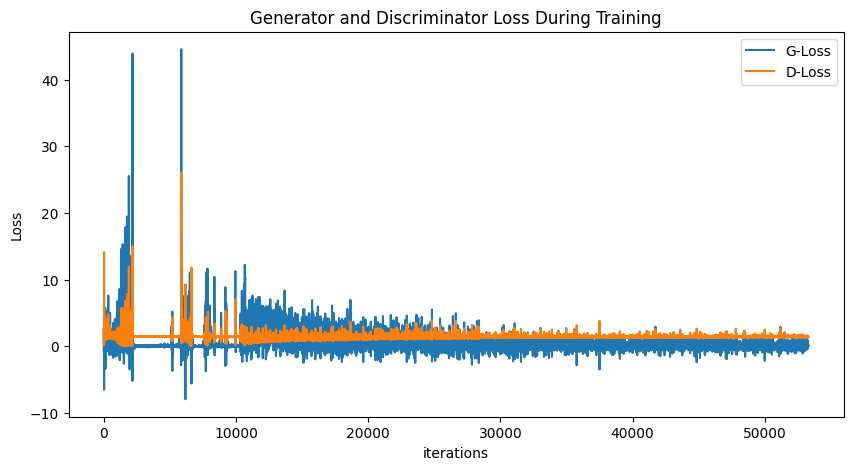

In [ ]:
if TRAIN:
  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss During Training")
  plt.plot(losses_G,label="G-Loss")
  plt.plot(losses_D,label="D-Loss")
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [ ]:
normalized_predictions = gan.predict(2, device)
boundary = int(len(tokenizer) / 2)
predictions = [x * boundary + boundary for x in normalized_predictions]

In [ ]:
n_generations = 1
base_name = "generated"

gan.generate(
    n                 = n_generations,
    base_output_name  = base_name,
    device            = device,
)

In [ ]:
display_audio(f"{base_name}_1.mid")